***
# Fundamentals of Data Analytics Assessment - CAO Points Analysis

***

<br>

<br>

![img](images/cao_logo.png)

<br>

<br>

Students who wish to study at third level in the Republic of Ireland apply to colleges and universities through the Central Applications Office (CAO) [1]. "The purpose of the Central Applications Office (CAO) is to process centrally applications for undergraduate courses in Irish Higher Education Institutions" [2].
 
“The CAO awards points to students based on their achievements in the Leaving Certificate examination. A student's points are calculated according to these tables (see below), counting their best six subjects only” [3]. A student can study a subject at higher or ordinary level - more points are awarded for higher level papers. Since 2012, the maximum number of points a student can receive is 625 points [3].



<br>

<br>

![img](images/points.jpg)

<br>

The entry points needed for a course is dependent on demand. This means the points requirements for a course varies year on year.  

<br>

This notebook will focus on comparing the CAO points for 2019, 2020 and 2021 and provide an overview of how to load the points from the CAO website into a pandas dataframe.

<br>

***
***

<br>

### Importing Libraries 

<br>

In [1]:
# Convenient HTTP requests.
import requests as rq

# Regular expressions.
import re

# Dates and times.
import datetime as dt

# Data frames.
import pandas as pd

# Working with data
import numpy as np

# For downloading.
import urllib.request as urlrq

# For scraping data from pdf
import camelot

# Unzipping folders 
from zipfile import ZipFile

# To merge csv files into one
import os, glob

# Common string operations
import string as str

<br>

In [2]:
# Visualisation
import matplotlib.pyplot as plt

# Visualisation
import seaborn as sns

# Standard plot size.
plt.rcParams['figure.figsize'] = (15, 10)

# Selecting a colour scheme.
plt.style.use('ggplot')

# Configures matplotlib to show figures embedded in the notebook. 
%matplotlib inline

<br>

In [3]:
# Get the current date and time.
now = dt.datetime.now()

# Format as a string.
nowstr = now.strftime('%Y%m%d_%H%M%S')

<br>

<br>

***
****

<br>

## 2021 CAO Points


<br>

***

<br>

### Level 8  
[Link to 2021 CAO points (Level 8)]('http://www2.cao.ie/points/l8.php')

<br>

<br>

As the 2021 points are storedas a html file on the CAO website, we must make a request to the server the are stored on. We can easily do this by using the python requests package which makes HTTP requests easily and simple and "human friendly". "The HTTP request returns a Response Object with all the response data (content, encoding, status, etc)" [4].

<br>

<br>

#### Server Request

<br>

In [4]:
# Get the CAO points URL
resp = rq.get('http://www2.cao.ie/points/l8.php')

# 200 = ok. 404 = error: not found
resp

<Response [200]>

<br>

<br>

#### Save Orignal Dataset


<br>

To save the orignal HTML file from the request we need to create a path in our repository. Using the datetime module we can convert the response request date to the day the request was made. 

<br>

In [5]:
# Create a file path for the original data.
pathhtml = 'datasets/cao2021_' + nowstr + '.html'

<br>

<br>

### Webserver Error


<br>

The CAO website throws an error - it tells us to decode in iso-8859-1 but, this isn't possible as some of the lines inculdes \x96 - a fada - which isn't recongised in iso-8859-1. To combat this we use tje decoding standard cp1252 which inculdes \x96 which allows the fada to be understood. 

<br>

Webserver error - server says decode as:

    Content-Type: text/html; charset=iso-8859-1
However, one line uses \x96 which isn't defined in iso-8859-1. 

Therefore, a similar decoding standard cp1252 was used. It is similar but inculdes #\x96

<br>

<br>

In [6]:
# Fixing the webserves wrong encoding
original_encoding = resp.encoding

# Changing to cp1252
resp.encoding = 'cp1252'

<br>

In [7]:
# Save the original html file.
with open(pathhtml, 'w') as f: # Opening path in write mode
    f.write(resp.text)

<br>

<br>

<br>

### Getting The Data


[Link To Regular Expression Documentation]('https://docs.python.org/3/library/re.html')

<br>

To get the relevant lines from the response request, we employ a regular expression. A regualr expression "...is a sequence of characters that specifies a search pattern" [5]. You can think of them as as a search and find function. We use a regular expression as it  more efficent than constantly recalling an expression over and over.

<br>

In [8]:
# Compile regular expression for matching lines.
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)') # r for raw data

<br>

<br>

We will then use this expression to loop through the response from earlier for any matches of the regular expression and save these matches in a CSV file. 

NB: verified as of 03/11/2021 that there were 949 courses on the CAO Level 8 2021 points list.

<br>

<br>

In [9]:
# Path to csv file
path2021 = 'datasets/cao2021_csv_' + nowstr + '.csv'

<br>

In [10]:
# Tracking number of courses matched
no_lines = 0



# Open the csv file for writing.
with open(path2021, 'w') as f:
    # Write a header row.
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')
    # Loop through lines of the response.
    for line in resp.iter_lines():
        # Decode the line, using the wrong encoding!
        dline = line.decode('cp1252')
        # Match only the lines representing courses.
        if re_course.fullmatch(dline):
            # Add one to the lines counter.
            no_lines = no_lines + 1
            # The course code.
            course_code = dline[:5] # i.e first 5 characters
            # The course title.
            course_title = dline[7:57].strip() # Strip gets rid of whitespace
            # Round one points.
            course_points = re.split(' +', dline[60:]) # split into substringd from index 60 
            if len(course_points) != 2: # This is because last course has an extra substring
                course_points = course_points[:2]
            # Join the fields using a comma.
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between.
            f.write(','.join(linesplit) + '\n')

            
            
            
            
# Number of courses matched
print(f"Total number of lines is {no_lines}.")

Total number of lines is 949.


<br>

<br>

<br>

<br>

In [11]:
# Reading dataframe
df2021 = pd.read_csv(path2021, encoding='cp1252')

In [12]:
df2021

,code,title,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


<br>

<br>

As we know these are all level 8 courses, we will also insert a new column into the dataframe to show this.

<br>

<br>

In [13]:
# Creating a new column at the second index with the value 8
df2021.insert(2, 'level', '8')
df2021

,code,title,level,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,8,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,8,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,8,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,8,321,NaN
4,AL810,Quantity Surveying,8,328,NaN
...,...,...,...,...,...
944,WD211,Creative Computing,8,270,NaN
945,WD212,Recreation and Sport Management,8,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,8,230,230
947,WD231,Early Childhood Care and Education,8,266,NaN


<br>

<br>

<br>

***

<br>

## Level 6/7 Courses

<br>

To retrive the 2021 level 6 and 7 courses we repeat this process.

<br>

### Server Request

<br>

In [14]:
# Fetch the CAO points URL.
resp = rq.get('http://www2.cao.ie/points/l76.php')

# 200 = ok. 404 = error: not found
resp

<Response [200]>

<br>

<br>

### Save Orignal Dataset



<br>

In [15]:
# Create a file path for the original data.
pathhtml_2 = 'datasets/cao2021_2' + nowstr + '.html'

<br>

<br>

### Webserver Error


<br>

In [16]:
# Fixing the webserves wrong encoding
original_encoding = resp.encoding

# Changing to cp1252
resp.encoding = 'cp1252'

<br>

In [17]:
# Save the original html file.
with open(pathhtml_2, 'w') as f: # Opening path in write mode
    f.write(resp.text)

<br>

<br>

### Getting The Data


<br>

In [18]:
# Compile regular expression for matching lines.
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)') # r for raw data

<br>

<br>

In [19]:
# Path to csv file
path2021_2 = 'datasets/cao2021_2_csv_' + nowstr + '.csv'

<br>

In [20]:

# KTracking number of courses matched
no_lines = 0



# Open the csv file for writing.
with open(path2021_2, 'w') as f:
    # Write a header row.
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')
    # Loop through lines of the response.
    for line in resp.iter_lines():
        # Decode the line, using the wrong encoding!
        dline = line.decode('cp1252')
        # Match only the lines representing courses.
        if re_course.fullmatch(dline):
            # Add one to the lines counter.
            no_lines = no_lines + 1
            # The course code.
            course_code = dline[:5]
            # The course title.
            course_title = dline[7:57].strip()
            # Round one points.
            course_points = re.split(' +', dline[60:])
            if len(course_points) != 2:
                course_points = course_points[:2]
            # Join the fields using a comma.
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between.
            f.write(','.join(linesplit) + '\n')


            
# Number of courses matched
print(f"Total number of lines is {no_lines}.")

Total number of lines is 416.


<br>

<br>

In [21]:
# Reading dataframe
df2021_2 = pd.read_csv(path2021_2, encoding='cp1252')

<br>

Unfortunatly, the 2021 level 6 and 7 courses aren't distingushed from each other. So, I've decided to insert them as '6/7' under a new column heading 'level'. This will distingush them from the courses we know for certain are level 8.

<br>

In [22]:
# Creating a new column at the second index
df2021_2.insert(2, 'level', '6/7')
df2021_2

,code,title,level,pointsR1,pointsR2
0,AL605,Music and Instrument Technology,6/7,211,NaN
1,AL630,Pharmacy Technician,6/7,308,NaN
2,AL631,Dental Nursing,6/7,311,NaN
3,AL632,Applied Science,6/7,297,NaN
4,AL650,Business,6/7,AQA,AQA
...,...,...,...,...,...
411,WD188,Applied Health Care,6/7,220,NaN
412,WD205,Molecular Biology with Biopharmaceutical Science,6/7,AQA,262v
413,WD206,Electronic Engineering,6/7,180,NaN
414,WD207,Mechanical Engineering,6/7,172,NaN


<br>

<br>

<br>

***

## 2020 Points
***

https://www.cao.ie/index.php?page=points&p=2020

<br>

Luckily the 2020 points are already available in a excel file. This equates to a simpler workload! Additionally, level 6, 7 and 8 are all inculded and are clearly marked.

<br>

<br>

In [23]:
# Saving the URL as a variable
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

<br>

<br>

### Saving Orginal Data

<br>

We must save a copt of the orignal file, we do this with the datetime module which keeps tabs on when the request was made. 

<br>

In [24]:
# Create a file path for original data
pathxlsx = 'datasets/cao2020_' + nowstr + '.xlsx'

<br>

<br>

### Retrieve Data

<br>

To get the data we can use the Urllib package. Urlib is a "...URL handling module for python. It is used to fetch URLs" [6]. The retrieve method downloads "...the remote data directly to the local [disk]" [7]. 

In [27]:
# Getting data
urlrq.urlretrieve(url2020, pathxlsx)

('datasets/cao2020_20211208_185749.xlsx',
 <http.client.HTTPMessage at 0x1d4f2563a30>)

<br>

<br>

### Loading The Spreadsheet

<br>

We can now load the data into the notebook by using pandas. The first 10 lines of the file inculde a blurb about the CAO so we will skip the first 10 rows to avoid pulling them into the newly created dataframe. 

<br>

In [28]:
# Download and parse the excel spreadsheet. First few rows where a blurb
df2020 = pd.read_excel(url2020, skiprows=10)

In [29]:
# Checking the dataframe
df2020

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

<br>

<br>

In [30]:
# Checking random row
df2020.iloc[1000]

CATEGORY (i.e.ISCED description)    Engineering and engineering trades
COURSE TITLE                                    Mechanical Engineering
COURSE CODE2                                                     SG333
R1 POINTS                                                          216
R1 Random *                                                        NaN
R2 POINTS                                                          NaN
R2 Random*                                                         NaN
EOS                                                                216
EOS Random *                                                       NaN
EOS Mid-point                                                      347
LEVEL                                                                7
HEI                                     Institute of Technology, Sligo
Test/Interview #                                                   NaN
avp                                                                NaN
v     

<br>

<br>

In [31]:
# -1 is always last row/element
df2020.iloc[-1]

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Mechanical and Manufacturing Engineering
COURSE CODE2                                                           WD230
R1 POINTS                                                                253
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      253
EOS Random *                                                             NaN
EOS Mid-point                                                            369
LEVEL                                                                      8
HEI                                        Waterford Institute of Technology
Test/Interview #                                                         NaN

<br>

<br>

<br>

<br>

<br>

### Storing The Dataframe

<br>

Storing the dataframe we created with the other files in the project directory.~

<br>

In [32]:
# Creating a path for dataframe
path2020 = 'datasets/cao2020_' + nowstr + '.csv'

<br>

In [33]:
# Saving dataframe to disk
df2020.to_csv(path2020)

<br>

<br>

<br>

<br>

***

## 2019 Points
***



<br>

### Level 8 Courses
https://www.cao.ie/index.php?page=points&p=2019

<br>

The 2019 CAO points are stored in PDF files. Only round 1 points are available for 2019.

<br>

I decided to use the package Camelot to extract the data from the files. [The Documentation for Camelot can be found here](https://camelot-py.readthedocs.io/en/master/user/quickstart.html).

Camelot has a number of [dependencies](https://camelot-py.readthedocs.io/en/master/user/install-deps.html) which must be installed before the package can be used.  I found [this](https://www.youtube.com/watch?v=LoiHI-IB3lY&t=308s) video extremely useful in getting Camelot up and running.

<br>

<br>

### Getting The Data

<br>

In [34]:
# Checking all pages of pdf for data
pdf = camelot.read_pdf('datasets/2019_points.pdf', pages='all')

<br>

In [35]:
# Checking the type
print(type(pdf))

<class 'camelot.core.TableList'>


<br>

<br>

Note: The number of pages in the 2019 level 8 courses PDF is 18.

<br>

In [36]:
# Checking the number of tables found
pdf

<TableList n=18>

<br>

In [37]:
# checking tothe accuracy
pdf[1].parsing_report

{'accuracy': 100.0, 'whitespace': 2.73, 'order': 1, 'page': 2}

<br>

From the parsing report we can see the table was extracted correctly. You can check this with all pages.

<br>

<br>

### Exporting Data

<br>

The next step is to export the data found into a CSV file so we can convert it into a dataframe. By passing '''compress=True''' camelot will create a zipped folder in the specified path. This will prevent - 18 in this case - CSV files being stored. 

<br>

In [38]:
# Exporting tables into a csv file
pdf.export('datasets/2019_points.csv', f='csv', compress=True)

<br>

<br>

To unzip the CSV files with use the Zipfile package [8]. 

<br>

In [39]:
# Loop through zipped folder for files
with ZipFile('datasets/2019_points.zip', 'r') as df:
   # Extract all the contents of zip file in current directory
   df.extractall('2019_points')

<br>

<br>

### Merging CSV Files

<br>

As camelot exports each table as a single file, we need to merge them all into one dataframe. We can do this by using the Glob module. Glob, which stands for global, is part of the standard Python library. 

It is used to "...search for a specific file pattern, or perhaps more usefully, search for files where the filename matches a certain pattern by using wildcard characters" [9].

<br>

<br>

In [40]:
# The path to use
path = '2019_points/'

<br>

In [41]:
# Find csvs which match this pattern
filelist = glob.glob(path + '2019_*.csv')

# Merge them together with these column headings
df2019 = pd.concat([pd.read_csv(file, names=['code','title','points','median' ]) for file in filelist])

<br>

<br>

<br>

<br>

<br>

As we know these are all level 8 courses, we will also insert a new column into the dataframe to show this. We will also clean up the dataframe a bit by dropping the old heading and by getting rid of the rows which only contain the name of the third level institutes.

<br>

<br>

In [42]:
# Creating a new column at the second index
df2019.insert(2, 'level', '8')

<br>

In [43]:
# Dropping old heading
df2019.drop(0)

,code,title,level,points,median
1,NaN,Athlone Institute of Technology,8,NaN,NaN
2,AL801,Software Design with Virtual Reality and Gaming,8,304,328
3,AL802,Software Design with Cloud Computing,8,301,306
4,AL803,Software Design with Mobile Apps and Connected...,8,309,337
5,AL805,Network Management and Cloud Infrastructure,8,329,442
...,...,...,...,...,...
50,TR032,Engineering,8,487*,520.0
51,TR033,Computer Science,8,465*,488.0
52,TR034,Management Science and Information Systems Stu...,8,589*,602.0
53,TR035,Theoretical Physics,8,554,601.0


<br>

In [44]:
# Getting rid of rows containing institute names only
df2019 = df2019[df2019['code'].notnull()]

<br>

In [45]:
# Checking last 5 rows
df2019.tail()

,code,title,level,points,median
50,TR032,Engineering,8,487*,520.0
51,TR033,Computer Science,8,465*,488.0
52,TR034,Management Science and Information Systems Stu...,8,589*,602.0
53,TR035,Theoretical Physics,8,554,601.0
54,TR038,Engineering with Management,8,499,543.0


<br>

<br>

<br>

<br>

<br>

***

<br>

### Level 6 & 7 Courses

http://www2.cao.ie/points/lvl76_19.pdf

<br>

To retrive the 2019 level 6 and 7 courses we repeat this process. 

<br>

### Getting The Data

<br>

There are 10 pages in the level 6 and 7 courses PDF.

<br>

In [46]:
# Checking all pages of pdf for data
pdf_2 = camelot.read_pdf('datasets/2019_points_2.pdf', pages='all')

<br>

In [47]:
# Checking the number of tables, should be 10
pdf_2

<TableList n=10>

<br>

<br>

In [48]:
# checking to make sure it worked
pdf_2[3].parsing_report

{'accuracy': 100.0, 'whitespace': 9.26, 'order': 1, 'page': 4}

<br>

<br>

<br>

<br>

### Exporting The Data

<br>

<br>

In [49]:
# Exporting tables into a csv file
pdf_2.export('datasets/2019_points_2.csv', f='csv', compress=True)

<br>

<br>

In [50]:
# Unzipping the folder - multiple tables are exported as a zip
# Loop through zipped folder for files
with ZipFile('datasets/2019_points_2.zip', 'r') as df:
   # Extract all the contents of zip file in current directory
   df.extractall('2019_points_2')

<br>

<br>

### Merging CSV Files

<br>

In [51]:
# Creating a path
path = '2019_points_2/'

<br>

<br>

In [52]:
# Find csvs which match this pattern
filelist = glob.glob(path + '2019_*.csv')

# Merge them together with these column headings. Leaving blurb from pdf without skiprows
df2019_2 = pd.concat([pd.read_csv(file, names=['code','title','points','median'], skiprows=10) for file in filelist])

<br>

<br>

Unfortunatly, the 2019 level 6 and 7 courses aren't distingushed from each other. In tandem with 2021, I decided to insert them as '6/7' under a new column heading 'level'. This will distingush them from the courses we know for certain are level 8. Additionally, we will get rid of the rows which only contain the name of the third level institutes.

<br>

<br>

In [53]:
# Creating a new column at the second index
df2019_2.insert(2, 'level', '6/7')

<br>

In [54]:
# Getting rid of rows containing institute names only
df2019_2 = df2019_2[df2019_2['code'].notnull()]

<br>

In [55]:
# Checking pandas dataframe
df2019_2. head()

,code,title,level,points,median
0,AL600,Software Design,6/7,205,306.0
1,AL601,Computer Engineering,6/7,196,272.0
2,AL602,Mechanical Engineering,6/7,258,424.0
3,AL604,Civil Engineering,6/7,252,360.0
4,AL630,Pharmacy Technician,6/7,306,366.0


<br>

<br>

<br>

<br>

<br>

***
## Cleaning Up Dataframes & Data 
***

<br>

Let's clean up our dataframes by choosing the columns we will be using, merging the level 6, 7 and 8 level courses for 2019 and 2021 together and any duplicate values.'

<br>

### 2021

<br>

In [56]:
# Selecting columns level 8
level_8_2021 = df2021[['code', 'title', 'level',  'pointsR1', 'pointsR2']]

<br>

In [57]:
# Selecting columns level 6/7
level_6_2021 = df2021_2[['code', 'title', 'level',  'pointsR1', 'pointsR2']]

<br>

<br>

Pandas makes it super simple for us to combine our dataframes by performing concatenation. The concat method allows us "...to append either columns or rows from one DataFrame to another" [10].

<br>

![img](images/concat.png)

<br>

<br>

In [58]:
# Concatenating level 8 and 6/7 2021 courses
total2021 = pd.concat([level_8_2021, level_6_2021], ignore_index=True)
total2021

,code,title,level,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,8,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,8,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,8,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,8,321,NaN
4,AL810,Quantity Surveying,8,328,NaN
...,...,...,...,...,...
1360,WD188,Applied Health Care,6/7,220,NaN
1361,WD205,Molecular Biology with Biopharmaceutical Science,6/7,AQA,262v
1362,WD206,Electronic Engineering,6/7,180,NaN
1363,WD207,Mechanical Engineering,6/7,172,NaN


<br>

<br>

<br>

### 2020

<br>

As all courses are inculded in the one file for 2020 points we don't need to combine them. We will however create a new dataframe by choosing the column titles we will be using.

<br>

In [59]:
# Selecting coloumns
total2020 = df2020[['COURSE CODE2','COURSE TITLE', 'LEVEL']]

<br>

In [60]:
# Renaming columns
total2020.columns = ['code', 'title', 'level']

<br>

In [61]:
total2020

,code,title,level
0,AC120,International Business,8
1,AC137,Liberal Arts,8
2,AD101,"First Year Art & Design (Common Entry,portfolio)",8
3,AD102,Graphic Design and Moving Image Design (portfo...,8
4,AD103,Textile & Surface Design and Jewellery & Objec...,8
...,...,...,...
1459,WD208,Manufacturing Engineering,7
1460,WD210,Software Systems Development,8
1461,WD211,Creative Computing,8
1462,WD212,Recreation and Sport Management,8


<br>

<br>

<br>

### 2019

<br>

In [62]:
# Selecting columns level 8
level_8_2019 = df2019[['code', 'title', 'level', 'points']]

<br>

In [63]:
# Selecting columns level 6/7
level_6_2019 = df2019_2[['code', 'title', 'level', 'points']]

<br>

In [64]:
# Concatenating level 8 and 6/7 2021 courses
total2019= pd.concat([level_8_2019, level_6_2019], ignore_index=True)
total2019

,code,title,level,points
0,Course Code INSTITUTION and COURSE,NaN,8,EOS
1,AL801,Software Design with Virtual Reality and Gaming,8,304
2,AL802,Software Design with Cloud Computing,8,301
3,AL803,Software Design with Mobile Apps and Connected...,8,309
4,AL805,Network Management and Cloud Infrastructure,8,329
...,...,...,...,...
1304,WD173,Hospitality Studies,6/7,182.0
1305,WD174,Tourism,6/7,134.0
1306,WD175,Pharmaceutical Science,6/7,207.0
1307,WD177,"Science (Mol. Biology with Biopharm.,Food Scie...",6/7,NaN


<br>

<br>

<br>

<br>

### All Courses

<br>

Now that we have three smaller dataframes for each year, it's time to combine the code, title and level for each year into one. This will enable us to join the points for each year later on.

<br>

In [65]:
# Choosing columns
courses2021 = total2021[['code', 'title', 'level']]
courses2021

,code,title,level
0,AL801,Software Design for Virtual Reality and Gaming,8
1,AL802,Software Design in Artificial Intelligence for...,8
2,AL803,Software Design for Mobile Apps and Connected ...,8
3,AL805,Computer Engineering for Network Infrastructure,8
4,AL810,Quantity Surveying,8
...,...,...,...
1360,WD188,Applied Health Care,6/7
1361,WD205,Molecular Biology with Biopharmaceutical Science,6/7
1362,WD206,Electronic Engineering,6/7
1363,WD207,Mechanical Engineering,6/7


<br>

<br>

<br>

In [66]:
# Choosing column
courses2020 = df2020[['COURSE CODE2','COURSE TITLE', 'LEVEL']]

# Renaming columns
courses2020.columns = ['code', 'title', 'level2020']

courses2020

,code,title,level2020
0,AC120,International Business,8
1,AC137,Liberal Arts,8
2,AD101,"First Year Art & Design (Common Entry,portfolio)",8
3,AD102,Graphic Design and Moving Image Design (portfo...,8
4,AD103,Textile & Surface Design and Jewellery & Objec...,8
...,...,...,...
1459,WD208,Manufacturing Engineering,7
1460,WD210,Software Systems Development,8
1461,WD211,Creative Computing,8
1462,WD212,Recreation and Sport Management,8


<br>

<br>

<br>

In [67]:
# Choosing columns
courses2019 = total2019[['code', 'title', 'level']]

# Renaming columns
courses2019.columns = ['code', 'title', 'level2019']

courses2019

,code,title,level2019
0,Course Code INSTITUTION and COURSE,NaN,8
1,AL801,Software Design with Virtual Reality and Gaming,8
2,AL802,Software Design with Cloud Computing,8
3,AL803,Software Design with Mobile Apps and Connected...,8
4,AL805,Network Management and Cloud Infrastructure,8
...,...,...,...
1304,WD173,Hospitality Studies,6/7
1305,WD174,Tourism,6/7
1306,WD175,Pharmaceutical Science,6/7
1307,WD177,"Science (Mol. Biology with Biopharm.,Food Scie...",6/7


<br>

<br>

In [68]:
# Dropping old header row
courses2019.drop(0)

,code,title,level2019
1,AL801,Software Design with Virtual Reality and Gaming,8
2,AL802,Software Design with Cloud Computing,8
3,AL803,Software Design with Mobile Apps and Connected...,8
4,AL805,Network Management and Cloud Infrastructure,8
5,AL810,Quantity Surveying,8
...,...,...,...
1304,WD173,Hospitality Studies,6/7
1305,WD174,Tourism,6/7
1306,WD175,Pharmaceutical Science,6/7
1307,WD177,"Science (Mol. Biology with Biopharm.,Food Scie...",6/7


<br>

<br>

<br>

In [69]:
# Combining the above into one
allcourses = pd.concat([courses2021, courses2020, courses2019], ignore_index=True)

<br>

In [70]:
# Sorting values in ascending by the code column
allcourses.sort_values('code')

allcourses

,code,title,level,level2020,level2019
0,AL801,Software Design for Virtual Reality and Gaming,8,NaN,NaN
1,AL802,Software Design in Artificial Intelligence for...,8,NaN,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,8,NaN,NaN
3,AL805,Computer Engineering for Network Infrastructure,8,NaN,NaN
4,AL810,Quantity Surveying,8,NaN,NaN
...,...,...,...,...,...
4133,WD173,Hospitality Studies,NaN,NaN,6/7
4134,WD174,Tourism,NaN,NaN,6/7
4135,WD175,Pharmaceutical Science,NaN,NaN,6/7
4136,WD177,"Science (Mol. Biology with Biopharm.,Food Scie...",NaN,NaN,6/7


<br>

<br>

As we can see above there are duplicate rows i.e. courses which have ran in multiple years so they appear more than once. Let's get rid of these duplicates.

<br>

In [71]:
# Finding duplicate rows
allcourses[allcourses.duplicated()]

,code,title,level,level2020,level2019


<br>

In [72]:
# Dropping duplicates
allcourses.drop_duplicates()

,code,title,level,level2020,level2019
0,AL801,Software Design for Virtual Reality and Gaming,8,NaN,NaN
1,AL802,Software Design in Artificial Intelligence for...,8,NaN,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,8,NaN,NaN
3,AL805,Computer Engineering for Network Infrastructure,8,NaN,NaN
4,AL810,Quantity Surveying,8,NaN,NaN
...,...,...,...,...,...
4133,WD173,Hospitality Studies,NaN,NaN,6/7
4134,WD174,Tourism,NaN,NaN,6/7
4135,WD175,Pharmaceutical Science,NaN,NaN,6/7
4136,WD177,"Science (Mol. Biology with Biopharm.,Food Scie...",NaN,NaN,6/7


<br>

In [73]:
# Dropping duplicates which shared a code
allcourses.drop_duplicates(subset=['code'], inplace=True, ignore_index=True)

allcourses

,code,title,level,level2020,level2019
0,AL801,Software Design for Virtual Reality and Gaming,8,NaN,NaN
1,AL802,Software Design in Artificial Intelligence for...,8,NaN,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,8,NaN,NaN
3,AL805,Computer Engineering for Network Infrastructure,8,NaN,NaN
4,AL810,Quantity Surveying,8,NaN,NaN
...,...,...,...,...,...
1761,SG403,Applied Archaeology,NaN,NaN,6/7
1762,SG432,Environmental Protection,NaN,NaN,6/7
1763,TL712,Computing with Digital Media,NaN,NaN,6/7
1764,TL719,Culinary Arts,NaN,NaN,6/7


<br>

<br>

When inplace = True,  data is modified in place [11].

<br>

<br>

***
## Joining Points and Levels
***

<br>

<br>

When a dataframe is madeup of more than one dataframe we can set/change the index of this dataframe using pandas.

"[An] Index is like an address, that’s how any data point across the dataframe or series can be accessed. Rows and columns both have indexes, rows indices are called as index and for columns its general column names" [12]. 

As the 2019 points data doesn't inculde round 2 points data, I've decided against using them for this analysis. We will only be using the round 1 points.

<br>

<br>

In [74]:
# Setting the index as the code column
total2021.set_index('code', inplace=True)

# Column headings
total2021.columns = ['title', 'level', 'points_r1_2021', 'points_r2_2021']

<br>

In [75]:
# Setting the index of allcourses as the code column
allcourses.set_index('code', inplace=True)

<br>

<br>

"join() is an object function that lives on your DataFrame" [13]. By using join, it allows you choose which dataframe to join on. By default, pandas does a left join. 

<br>

![img](images/join.webp)

<br>

The next step is to join the points from each year to our dataframe which contains the course code and title.

<br>

In [76]:
# Joining 2021 points to the dataframe 
allcourses = allcourses.join(total2021[['points_r1_2021']])

<br>

<br>

In [77]:
# Getting columns with points
df2020_r1 = df2020[['COURSE CODE2', 'LEVEL', 'R1 POINTS', 'R2 POINTS']]

# Changing titles
df2020_r1.columns = ['code', 'level' ,'points_r1_2020', 'points_r2_2020']


<br>

<br>

In [78]:
# Setting the index as the code column
df2020_r1.set_index('code', inplace=True)

<br>

<br>

In [79]:
# Join 2020 points to allcourses.
allcourses = allcourses.join(df2020_r1, rsuffix='level2020')

<br>

<br>

By passing, in this case - rsuffix (right suffix), we're specifying "...a suffix to add to any overlapping columns" [14]. On the above join an error is thrown if the suffix isn't specified. We repeat for 2019 points.

<br>

<br>

In [80]:
# Getting columns with points
df2019_r1 = total2019[['code', 'points', 'level']]

# Changing titles
df2019_r1.columns = ['code', 'points_r1_2019', 'level_2019']

<br>

In [81]:
# Set the index to the code column.
df2019_r1.set_index('code', inplace=True)

<br>

In [82]:
# Join 2019 points to allcourses
allcourses = allcourses.join(df2019_r1, rsuffix='2019')

<br>

In [83]:
# Dropping columns not using
allcourses = allcourses.drop(['level2020', 'level2019', 'points_r2_2020'], axis=1)

<br>

In [84]:
allcourses

,title,level,points_r1_2021,levellevel2020,points_r1_2020,points_r1_2019,level_2019
code,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,8,300,8.0,303,304,8
AL802,Software Design in Artificial Intelligence for...,8,313,8.0,332,301,8
AL803,Software Design for Mobile Apps and Connected ...,8,350,8.0,337,309,8
AL805,Computer Engineering for Network Infrastructure,8,321,8.0,333,329,8
AL810,Quantity Surveying,8,328,8.0,319,307,8
...,...,...,...,...,...,...,...
SG403,Applied Archaeology,NaN,NaN,NaN,NaN,297,6/7
SG432,Environmental Protection,NaN,NaN,NaN,NaN,279,6/7
TL712,Computing with Digital Media,NaN,NaN,NaN,NaN,243.0,6/7


<br>

<br>

In [85]:
# Renaming the columns
allcourses.rename(columns={'level':'level_2021', 'levellevel2020': 'level_2020'}, inplace=True)

<br>

<br>

In [86]:
# Checking random course
allcourses.loc['CI001'] # Code is the index 

title             Counselling Skills and Psychotherapy Studies
level_2021                                                 NaN
points_r1_2021                                             NaN
level_2020                                                 7.0
points_r1_2020                                             300
points_r1_2019                                             238
level_2019                                                 6/7
Name: CI001, dtype: object

<br>

<br>

<br>

### Changing DataType
***

<br>

In [87]:
allcourses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1766 entries, AL801 to TL746
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1765 non-null   object 
 1   level_2021      1365 non-null   object 
 2   points_r1_2021  1336 non-null   object 
 3   level_2020      1464 non-null   float64
 4   points_r1_2020  1437 non-null   object 
 5   points_r1_2019  1297 non-null   object 
 6   level_2019      1309 non-null   object 
dtypes: float64(1), object(6)
memory usage: 174.9+ KB


<br>

<br>

As mentioned earlier, the 2020 points do provide the level for each course. The levels are saved as an interger. As we had to add our own level's into 2021 and 2019, where '6/7' was used. So I am going to convert the level column values into a string type to match 2019 and 2021.

<br>

<br>

In [88]:
# Converting level column values into strings
allcourses['level_2020'] = allcourses['level_2020'].astype('string')

<br>

<br>

As we can see above the datatype that the points are saved as strings. We need to change this into a numerical value so we can preform statistical operations such as - max, min, mean, etc. - on the data. 

Some of the points values have special characters next to them to indicate extra elements - interview, portfolio, etc. - required for a course. We need to remove these characters before we can covert the strings to numeric values, an error is thrown if not. 

Note: 2020 points don't contain any special characters.

<br>

<br>

In [89]:
# Converting level column values into strings
#allcourses['points_r1_2021'] = allcourses['points_r1_2021'].astype('string')
#allcourses['points_r1_2020'] = allcourses['points_r1_2020'].astype('string')
#allcourses['points_r1_2019'] = allcourses['points_r1_2019'].astype('string')

<br>

<br>

<br>

In [90]:
# 2021 points
allcourses['points_r1_2021'] = allcourses['points_r1_2021'].str.replace(r'\D', '', regex=True)

# 2019 points
allcourses['points_r1_2019'] = allcourses['points_r1_2019'].str.replace(r'\D', '', regex=True)

<br>

<br>

In [91]:
# Checking a courses which previously had a special character
allcourses.loc['CR125']

title             Popular Music at CIT Cork School of Music
level_2021                                                8
points_r1_2021                                         1028
level_2020                                              8.0
points_r1_2020                                         1088
points_r1_2019                                          972
level_2019                                                8
Name: CR125, dtype: object

<br>

<br>

In [92]:
# Converting points columns to numeric values
cols = ['points_r1_2021', 'points_r1_2020', 'points_r1_2019']
allcourses[cols] = allcourses[cols].apply(pd.to_numeric, errors='coerce', axis=1)

<br>

<br>

In [93]:
allcourses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1766 entries, AL801 to TL746
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1765 non-null   object 
 1   level_2021      1365 non-null   object 
 2   points_r1_2021  1317 non-null   float64
 3   level_2020      1464 non-null   string 
 4   points_r1_2020  1387 non-null   float64
 5   points_r1_2019  1227 non-null   float64
 6   level_2019      1309 non-null   object 
dtypes: float64(3), object(3), string(1)
memory usage: 174.9+ KB


<br>

<br>

<br>

<br>

***
## Data Analysis
***

<br>

<br>

![img](images/covid.jpg)

<br>

<br>

Before we start with a points comparison, it is important to note the impact Covid-19 had on the leaving certificate and CAO points. 

On the 21st of May 2020, the government announced that due to medical evidence the leaving certificate exam would be canceled [15]. In it’s place students were offered the option of calculated grades or to sit the exam at a later date. In figures released by the The Department of Education revealed over  98% students had registered for calculated grades [16].

In 2021, students again had the option of sitting exams, recieving accredited grades or a mixture of both [17]. 

There was an overall concern that accredited grades along with a record number of applicants would drive up CAO points for courses across the board. Let’s investigate if that was indeed the case.


<br>

In [102]:
# Overview 
allcourses.describe()

,points_r1_2021,points_r1_2020,points_r1_2019
count,1317.000000,1387.000000,1227.000000
mean,361.665148,350.217015,340.366748
std,139.025919,134.311616,132.806330
min,57.000000,55.000000,55.000000
25%,260.000000,252.000000,252.000000
50%,325.000000,316.000000,307.000000
75%,462.000000,430.500000,409.500000
max,1028.000000,1088.000000,979.000000


<br>

<br>

Just from this quick overview, we can see that points have increased over the years. 

<br>

<br>

In [144]:
# Number of courses titles
allcourses['title'].count()

1765

<br>

<br>

There are 1765 courses in our dataframe. It's important to note that this does not mean there was 1674 courses available to candidates each year. The number of courses varies year on year. If there's low demand for courses, they may cease that and subsequent years. Additionally, new courses may be added. 

<br>

<br>

In [147]:
# Breakdown of 2019 courses
allcourses['level_2019'].value_counts()

8      931
6/7    378
Name: level_2019, dtype: int64

<br>

<br>

In [ ]:
# Breakdown of 2020 courses
allcourses['level_2020'].value_counts()

8.0    1027
7.0     346
6.0      91
Name: level_2020, dtype: Int64

<br>

<br>

In [146]:
# Breakdown of 2021 courses
allcourses['level_2021'].value_counts()

8      949
6/7    416
Name: level_2021, dtype: int64

<br>

Let's visualise these numbers using a countplot.

<br>

<AxesSubplot:xlabel='level_2021', ylabel='count'>

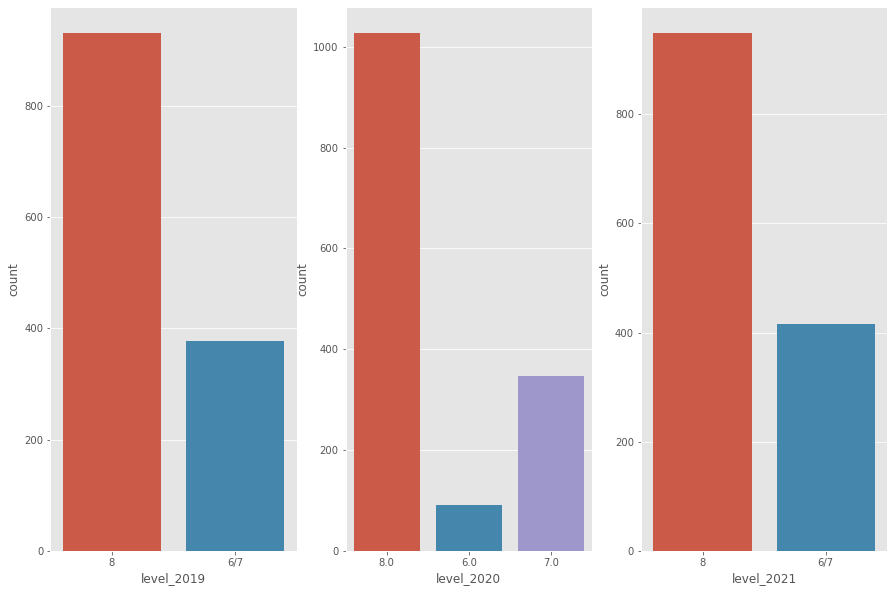

In [148]:
# Figure Size
plt.rcParams['figure.figsize'] = (15, 10)

# Generating a countplot for each year

# nrows, ncols, the first plot
plt.subplot(1,3,1)
sns.countplot(x='level_2019', data=allcourses)

# nrows, ncols, the second plot
plt.subplot(1,3,2)
sns.countplot(x='level_2020', data=allcourses)

# nrows, ncols, the thrid plot
plt.subplot(1,3,3)
sns.countplot(x='level_2021', data=allcourses)


<br>

2020 was the year which offered students the greatest number of courses.

<br>

<br>

In [104]:
# Average number of points 2020
allcourses['points_r1_2020'].mean()

350.21701514059123

<br>

<br>

<br>

Next, let's take a look at the points. 

<br>

<br>

#### KDE Plot

<br>

"A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset" [18].

The KDE plot is generated by “…drawing a small continuous curve (also called kernel) for every individual data point along an axis, all of these curves are then added together to obtain a single smooth density estimation” [19].

<br>

([<matplotlib.axis.XTick at 0x1d4b07f22e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

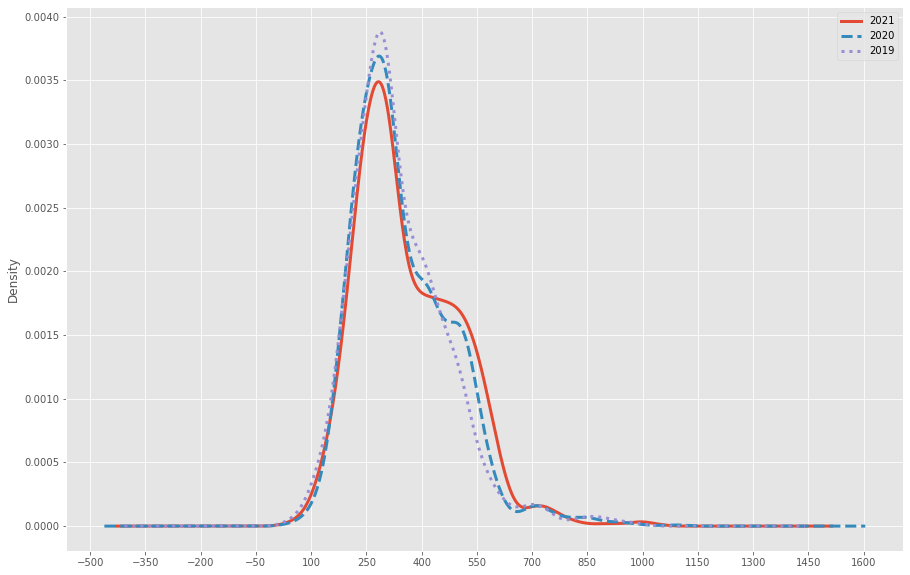

In [173]:
# Generating a kde plot for points 
allcourses['points_r1_2021'].plot.kde(label='2021', linestyle='-', linewidth=3)
allcourses['points_r1_2020'].plot.kde(label='2020', linestyle='--', linewidth=3)
allcourses['points_r1_2019'].plot.kde(label='2019', linestyle=':', linewidth=3)

# Adding a legend
plt.legend()

# Adding ticks to xaxis
plt.xticks(np.arange(-500, 1650, step=150))

<br>

<br>

From the above plot we can see that the majority of courses require in and around 300 points.

<br>

<br>

#### Scatterplot

<br>

Let's create a scatterplot to compare 2020 and 2021 points. I'm going to use the 2020 level of the course because the CAO distingushed between the levels for 2020. Whereas for 2019 and 2021 they didn't specify which was a level 6 and level 7 course.

Scatterplots are useful because, not only does each dot represent an individual, they also allow us to recognise any patterns in the data. It is common to discover and identify correlation of relationships when using scatter plots [20].

<br>

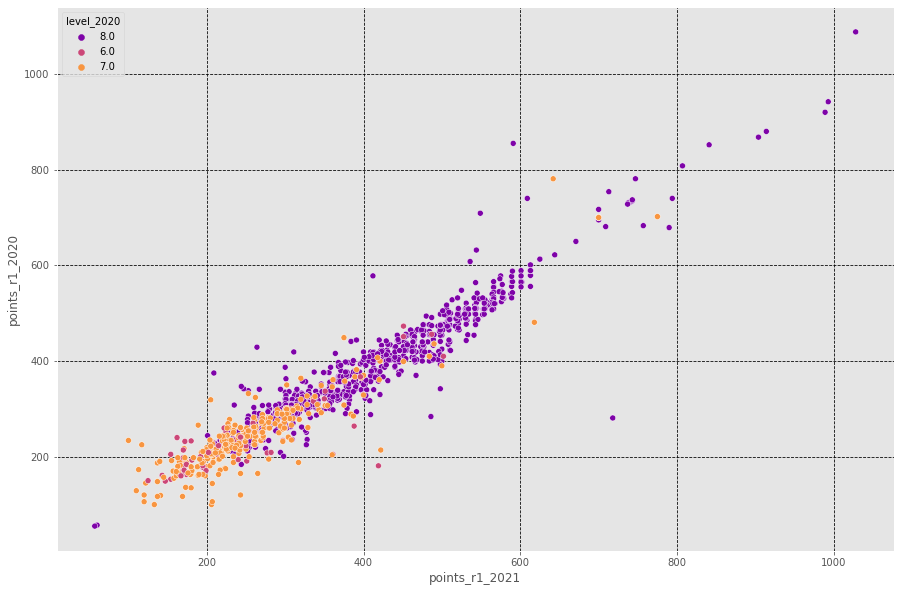

In [177]:
# Generating a scatterplot between 2020 and 2021 points.
    
sns.scatterplot(x=allcourses['points_r1_2021'], y=allcourses['points_r1_2020'], hue=allcourses['level_2020'], palette='plasma')

# Adding labels to axis
plt.xlabel('points_r1_2021')
plt.ylabel('points_r1_2020')

# Adding a grid
plt.grid(color='black',ls='--')

<br>

<br>

<br>

In [ ]:
# Pivot table of top 5 course points by 2019
allcourses.sort_values(by=['points_r1_2021', 'title'], ascending=False).head()

<br>

<br>

In [ ]:
# Pivot table of top 5 course points by 2019
allcourses.sort_values(by=['points_r1_2020', 'title'], ascending=False).head()

<br>

<br>

In [ ]:
# Pivot table of top 5 course points by 2019
allcourses.sort_values(by=['points_r1_2019', 'title'], ascending=False).head()

<br>

<br>

In [ ]:
x = allcourses.groupby(['level_2020'])[cols].agg([np.mean, np.std, np.min, np.max])

In [ ]:
x

<br>

In [ ]:
# Generating a barplot for the above pivot table
x.plot.barh()

<br>

<br>

<br>

In [ ]:
# Overview of 2021 points
allcourses['points_r1_2021'].describe()

<br>

<br>

In [ ]:
# Most points in 2021
allcourses['points_r1_2021'].max()

<br>

<br>

In [ ]:
# Least points in 2021
allcourses['points_r1_2021'].min()

<br>

<br>

<br>

In [ ]:
# Searching for that course
allcourses[allcourses['points_r1_2021'] == 625]

<br>

<br>

An increase of 80 points in 2 years. 

<br>

<br>

In [ ]:
# Searching for that course
allcourses[allcourses['points_r1_2021'] == 100]

<br>

A massive 134 point drop from 2020.

<br>

<br>

In [174]:
# Overview of 2020 points
allcourses['points_r1_2020'].describe()

count    1387.000000
mean      350.217015
std       134.311616
min        55.000000
25%       252.000000
50%       316.000000
75%       430.500000
max      1088.000000
Name: points_r1_2020, dtype: float64

<br>

<br>

In [94]:
# Most points in 2020
allcourses.max()

C:\Users\katie\AppData\Local\Temp/ipykernel_14052/2607426376.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  allcourses.max()


points_r1_2021    1028.0
level_2020           8.0
points_r1_2020    1088.0
points_r1_2019     979.0
dtype: object

<br>

<br>

In [ ]:
# Least points in 2020
allcourses['points_r1_2020'].min()

<br>

<br>

<br>

In [95]:
# Searching for that course
allcourses[allcourses['points_r1_2020'] == 1088]

,title,level_2021,points_r1_2021,level_2020,points_r1_2020,points_r1_2019,level_2019
code,,,,,,,
CR125,Popular Music at CIT Cork School of Music,8,1028.0,8.0,1088.0,972.0,8


<br>

<br>

The course with the most points was Popular Music at CIT Cork School of Music. This seems to be a new introduction in 2020, and it was in 2021 CAO.

<br>

<br>

In [ ]:
# Searching for that course
allcourses[allcourses['points_r1_2020'] == 55]

<br>

<br>

The course with the lowest points is misleading as it requires a GAMSAT*. 

*Graduate Medical School Admissions Test (GAMSAT) "is a standardised exam designed, scored and developed by ACER to assist in the admissions of students to graduate-entry programmes (medicine, dentistry, optometry, pharmacy, podiatry) open to graduates of any discipline.GRADUATE ENTRY IRISH MEDICAL SCHOOLS. There are 4 medicals schools in Ireland which require the GAMSAT as part of their admissions criteria."

<br>

<br>

In [175]:
# Overview of 2019 points
allcourses['points_r1_2019'].describe()

count    1227.000000
mean      340.366748
std       132.806330
min        55.000000
25%       252.000000
50%       307.000000
75%       409.500000
max       979.000000
Name: points_r1_2019, dtype: float64

<br>

<br>

In [176]:
# Most points in 2019
allcourses['points_r1_2019'].max()

979.0

<br>

<br>

In [ ]:
# Least points in 2019
allcourses['points_r1_2019'].min()

<br>

<br>

<br>

In [ ]:
# Searching for that course
allcourses[allcourses['points_r1_2019'] == 601]

<br>

<br>

Intrestingly the points went down from 2020, which we can assume was the first year of Popular Music at CIT Cork School of Music as it is not present in 2019.

<br>

<br>

In [ ]:
# Searching for that course
allcourses[allcourses['points_r1_2019'] == 100]

<br>

<br>

<br>

<br>

<br>

In [ ]:
# Getting skew and kurtosis for 2021 points
print("2021 points skewness: %f" % allcourses['points_r1_2021'].skew())
print("2021 points kurtosis: %f" % allcourses['points_r1_2021'].kurt())

# Formatting
print('******************************')

# Getting skew and kurtosis for 2020 points
print("2020 points skewness: %f" % allcourses['points_r1_2020'].skew())
print("2020 points kurtosis: %f" % allcourses['points_r1_2020'].kurt())

# Formatting
print('******************************')

# Getting skew and kurtosis for 2019 points
print("2019 points skewness: %f" % allcourses['points_r1_2019'].skew())
print("2019 points kurtosis: %f" % allcourses['points_r1_2019'].kurt())

<br>

<br>

<br>

<br>

In [ ]:
# Generating a pairplot
sns.pairplot(data=allcourses )

<br>

<br>

<br>

<br>

Similar to Excel, we can create pivot tables. Which takes the following parameters:

- values – a list of variables to calculate statistics for.
- index – a list of variables to group data by
- aggfunc – what statistics we need to calculate for groups, ex. sum, mean, maximum, minimum or something else.

<br>

In [138]:
# Generating a pivot table 
allcourses.pivot_table(['points_r1_2020'],['level_2020'], aggfunc='count')

,points_r1_2020
level_2020,
6.0,74
7.0,329
8.0,984


<br>

<br>

<br>

In [97]:
allcourses.pivot_table(['points_r1_2021', 'points_r1_2020', 'points_r1_2019'],['level_2020'], aggfunc='min')

,points_r1_2019,points_r1_2020,points_r1_2021
level_2020,,,
6.0,128.0,149.0,120.0
7.0,100.0,100.0,100.0
8.0,55.0,55.0,57.0


<br>

<br>

In [101]:
allcourses.pivot_table(['points_r1_2021', 'points_r1_2020', 'points_r1_2019'],['level_2020'], aggfunc='mean')

,points_r1_2019,points_r1_2020,points_r1_2021
level_2020,,,
6.0,227.586957,235.283784,243.724638
7.0,238.588889,245.714286,256.902280
8.0,384.831836,393.800813,408.978261


<br>

<br>

<br>

In [ ]:
allcourses.pivot_table(['points_r1_2021', 'points_r1_2020', 'points_r1_2019'],['level_2020'], aggfunc='median')

<br>

<br>

<br>

<br>

In [ ]:
corr = allcourses.corr()

In [ ]:
corr

In [ ]:
sns.heatmap(corr, cmap='coolwarm', annot=True)

<br>

<br>

In [ ]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

<br>

<br>

In [ ]:
sns.distplot(allcourses[allcourses['points_r1_2021']>0]['points_r1_2021'], fit=norm)


In [ ]:

stats.probplot(allcourses[allcourses['points_r1_2021']>0]['points_r1_2021'], plot=plt)

In [ ]:
# nrows, ncols, the first plot
plt.subplot(1,3,1)
(allcourses['points_r1_2021']).plot.box()

# nrows, ncols, the second plot
plt.subplot(1,3,2)
(allcourses['points_r1_2020']).plot.box()

# nrows, ncols, the thrid plot
plt.subplot(1,3,3)
(allcourses['points_r1_2019']).plot.box()


<br>

<br>

In [ ]:

plt.plot(allcourses["points_r1_2021"], label='2021')
plt.plot(allcourses["points_r1_2020"], label='2020')
plt.plot(allcourses["points_r1_2019"], label='2019')

plt.legend()

<br>

<br>

.plot() is a wrapper for pyplot.plot(), and the result is a graph identical to the one you produced with Matplotlib https://realpython.com/pandas-plot-python/

<br>

<br>

In [ ]:
median_2020 = allcourses["points_r1_2020"]

In [ ]:
median_2020.plot(kind='hist')

In [ ]:
median_2019 = allcourses["points_r1_2019"]

In [ ]:
median_2019.plot(kind='hist')

<br>

<br>

<br>

<br>

<br>

<br>

## References

#### Images

- [CAO Logo](https://www.icareer.ie/wp-content/uploads/2016/12/Untitled-1.jpg)
- [Points](https://www.irishtimes.com/polopoly_fs/1.3596890!/image/image.jpg)
- [Concat](https://pandas.pydata.org/pandas-docs/stable/_images/merging_concat_basic.png)
- [Join](https://www.datasciencemadesimple.com/wp-content/uploads/2017/09/join-or-merge-in-python-pandas-1.png?ezimgfmt=ng:webp/ngcb1)
- [Covid](https://www.bswrehab.com/-/media/project/baylorrehab/dotcom/usa/images/about-us/in-the-news/covid19visitationpolicy.jpg?h=256&iar=0&w=256&t=20200926000839&hash=B45A283413C03E8AFECD850719453F0F)

# End